In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np

aci_colour = 'royalblue'
adi_colour = 'darkorange'

colours = {
    'ACI': aci_colour,
    'ADI': adi_colour
}

# Sonic Data

In [ ]:
sonic_df = pd.read_csv('Sonic.csv', parse_dates=['Timestamp'])
sonic_df = sonic_df[sonic_df.loc[:,'ADI'] <= 1]
sonic_df

,Timestamp,ACI,ADI
0,2019-02-18 00:15:35,3069.9075,0.1324
1,2019-02-18 00:45:36,3079.1619,0.1421
2,2019-02-18 01:15:37,3058.3938,0.1448
3,2019-02-18 01:45:38,3107.4165,0.1336
4,2019-02-18 02:15:39,3086.7498,0.1278
...,...,...,...
4019,2019-07-17 11:06:55,3738.6733,0.2082
4020,2019-07-17 11:36:56,3431.6731,0.2099
4021,2019-07-17 12:06:57,3773.3103,0.2080
4022,2019-07-17 12:36:58,3882.5024,0.2223


In [ ]:
sonic_df = sonic_df[(np.abs(stats.zscore(sonic_df.loc[:,'ACI':'ADI'])) < 3).all(axis=1)]

## Hourly Range of ACI and ADI

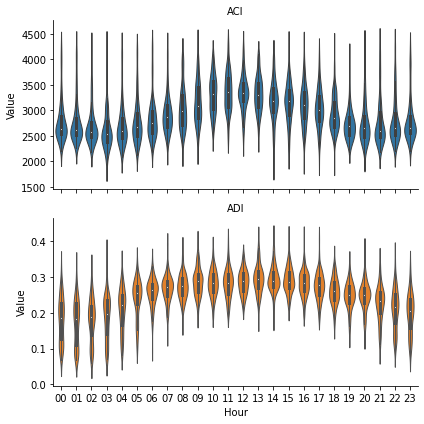

In [ ]:
sonic_df['Hour'] = sonic_df['Timestamp'].dt.strftime('%H')

sonic_month_melted = sonic_df.melt(id_vars=['Hour'], var_name='Metric', value_vars=['ACI','ADI'], value_name='Value')
order = list(sonic_month_melted['Hour'].unique())

g = sns.FacetGrid(sonic_month_melted, row="Metric", hue='Metric', sharey=False, aspect=2)
g.map(sns.violinplot, 'Hour', 'Value', order=order, linewidth=1)
g.set_titles(row_template="{row_name}")
g.savefig('hourly_indices.pdf')

## Weekday Range of ACI and ADI

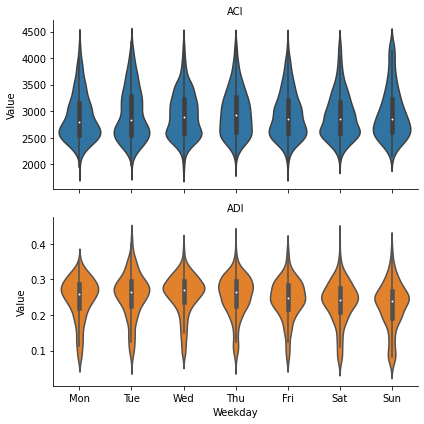

In [ ]:
sonic_df['Weekday'] = sonic_df['Timestamp'].dt.strftime('%a')
sonic_weekday_melted = sonic_df.melt(id_vars=['Weekday'], var_name='Metric', value_vars=['ACI','ADI'], value_name='Value')
order = ['Mon','Tue','Wed','Thu','Fri','Sat','Sun']

g = sns.FacetGrid(sonic_weekday_melted, row="Metric", hue='Metric', sharey=False, aspect=2)
g.map(sns.violinplot, 'Weekday', 'Value', order=order)
g.set_titles(row_template="{row_name}")
g.savefig('weekly_indices.pdf')

## Monthly of ACI and ADI

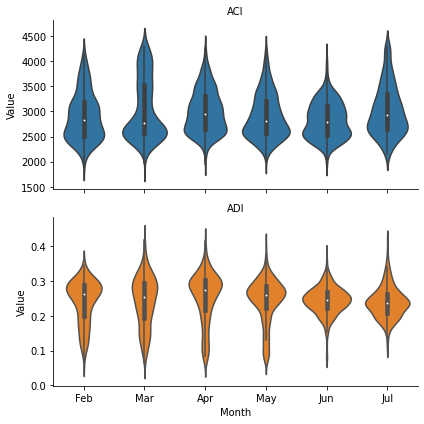

In [ ]:
sonic_df['Month'] = sonic_df['Timestamp'].dt.strftime('%b')
sonic_month_melted = sonic_df.melt(id_vars=['Month'], var_name='Metric', value_vars=['ACI','ADI'], value_name='Value')
order = list(sonic_month_melted['Month'].unique())

g = sns.FacetGrid(sonic_month_melted, row="Metric", hue='Metric', sharey=False, aspect=2)
g.map(sns.violinplot, 'Month', 'Value', order=order)
g.set_titles(row_template="{row_name}")
g.savefig('monthly_indices.pdf')

# Combined Data

In [ ]:
eco_df = pd.read_csv('Ecological.csv', parse_dates=['Timestamp'])
eco_df = eco_df[eco_df.loc[:,'ADI'] <= 1]
eco_df = eco_df[eco_df.loc[:,'Humidity'] <= 100.0]
eco_df

,Timestamp,ACI,ADI,Temperature,Humidity,Luminosity,Voltage
0,2019-05-11 15:00:00,3148.40665,0.5951,19.388740,39.736525,1194.102950,4.060485
1,2019-05-13 13:00:00,3424.68445,0.6312,10.626440,65.199975,174.656525,4.007870
2,2019-05-05 16:00:00,3459.26920,0.5760,12.212000,58.958290,393.096510,3.873020
3,2019-03-26 08:00:00,2962.10730,0.5836,7.322105,82.768820,359.876005,3.807890
5,2019-06-24 19:00:00,2641.96935,0.4665,18.470010,60.814765,58.026750,3.890070
...,...,...,...,...,...,...,...
3579,2019-03-11 15:00:00,3699.10365,0.5850,9.700465,42.631920,354.845675,3.991360
3581,2019-04-26 18:00:00,2781.67140,0.2706,17.765425,65.169220,99.834010,4.160185
3582,2019-05-29 21:00:00,2573.16015,0.4446,4.452015,90.804515,0.601545,3.920615
3583,2019-06-15 08:00:00,2801.27565,0.5159,25.105430,63.457610,334.049520,3.847780


Augment with week number

In [ ]:
eco_df['Week Number'] = eco_df['Timestamp'].dt.strftime('%U').astype(int)
eco_df['Month'] = eco_df['Timestamp'].dt.strftime('%m').astype(int)

In [ ]:
# g = sns.pairplot(eco_df, diag_kind="kde", x_vars=['ACI','ADI','Temperature','Humidity','Luminosity'],
#                  y_vars=["ACI", "ADI"], hue='Week Number',
#                  palette=sns.diverging_palette(240, 10, n=len(list(eco_df['Week Number'].unique()))))
# g.savefig('pairplot.pdf')

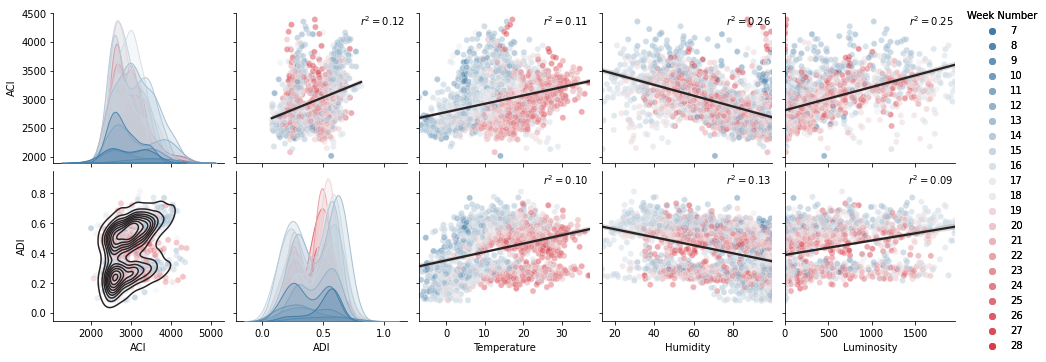

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import statsmodels.api as sm
import random

def customreg(x, y, hue=None, scatter_kws={}, reg_kws={}, **kwargs):
  sns.scatterplot(x, y, hue, palette=kwargs.get('palette'), **scatter_kws)
  sns.regplot(x, y, scatter=False, **reg_kws)

  # Calc R2
  x = sm.add_constant(x)

  model = sm.OLS(y, x)
  results = model.fit()

  plt.gca().annotate('$r^2=${:0.2f}'.format(results.rsquared), xy=(0.99,0.99), xycoords='axes fraction',
                     horizontalalignment='right', verticalalignment='top')

def customkde(x, y, hue, **kwargs):
  sns.kdeplot(x, y, **kwargs)

g = sns.pairplot(eco_df, x_vars=['ACI','ADI','Temperature','Humidity','Luminosity'],
                y_vars=["ACI", "ADI"], hue='Week Number', plot_kws={'alpha': 0.3},
                palette=sns.diverging_palette(240, 10, n=len(list(eco_df['Week Number'].unique()))))
g.map_upper(customreg, scatter_kws={'alpha': 0.3}, reg_kws={'color':sns.diverging_palette(240, 10, n=3, center='dark')[1]})
g.map_lower(customkde, levels=10, color=sns.diverging_palette(240, 10, n=3, center='dark')[1])
# g.map_diag(sns.kdeplot)
g.add_legend()
g.savefig('pairplot_week.pdf')

GET R VALUES FOR LINES

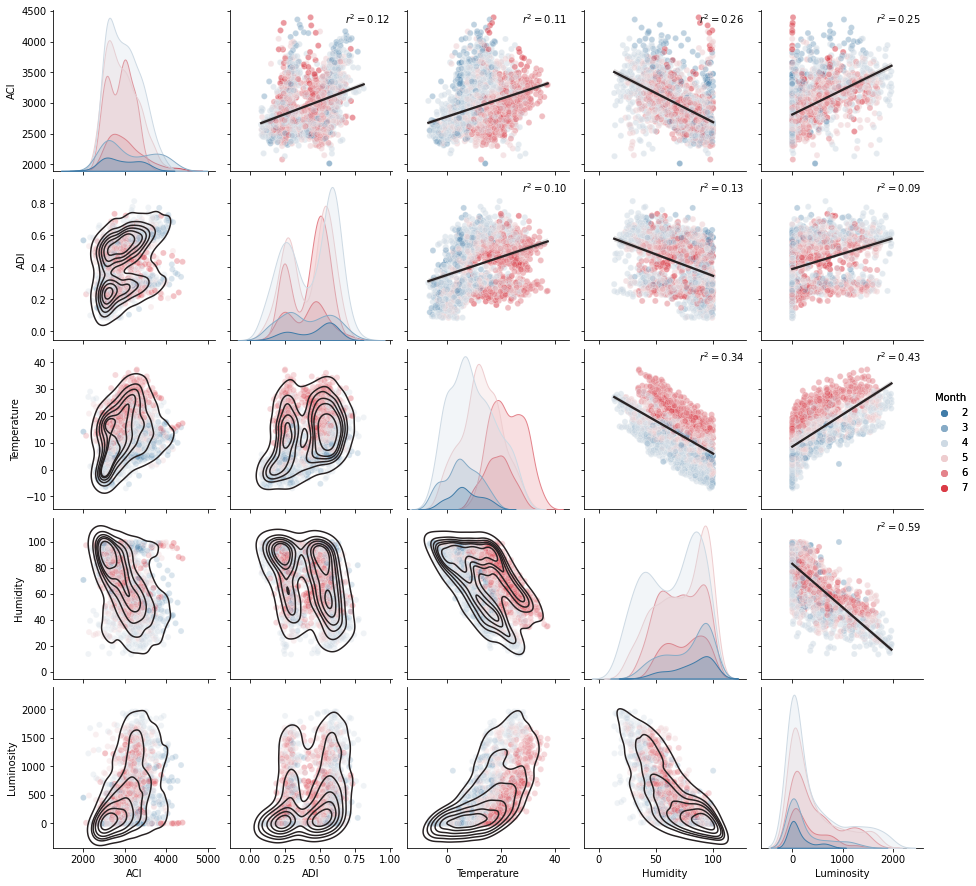

In [ ]:
g = sns.pairplot(eco_df, x_vars=['ACI','ADI','Temperature','Humidity','Luminosity'],
                # y_vars=["ACI", "ADI"],
                y_vars=['ACI','ADI','Temperature','Humidity','Luminosity'],
                 hue='Month', plot_kws={'alpha': 0.3},
                palette=sns.diverging_palette(240, 10, n=len(list(eco_df['Month'].unique()))))
g.map_upper(customreg, scatter_kws={'alpha': 0.3}, reg_kws={'color':sns.diverging_palette(240, 10, n=3, center='dark')[1]})
g.map_lower(customkde, levels=7, color=sns.diverging_palette(240, 10, n=3, center='dark')[1])
# g.map_diag(sns.kdeplot)
g.add_legend()
g.savefig('pairplot_month.pdf')

## Playground

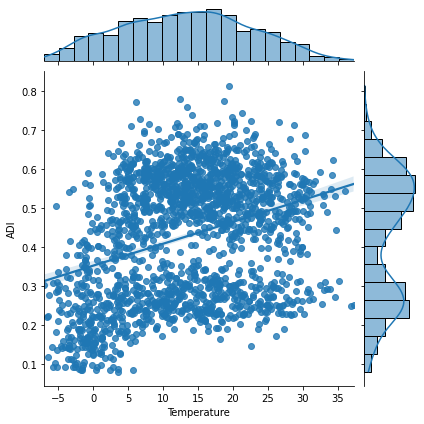

In [ ]:
sns.jointplot(data=eco_df, x="Temperature", y="ADI", kind="reg")

In [ ]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

x, y = eco_df['Temperature'], eco_df['ADI']
x = sm.add_constant(x)

model = sm.OLS(y, x)
results = model.fit()

print(results.summary())

print('{:0.2f}'.format(results.rsquared))

                            OLS Regression Results                            
Dep. Variable:                    ADI   R-squared:                       0.103
Model:                            OLS   Adj. R-squared:                  0.103
Method:                 Least Squares   F-statistic:                     213.2
Date:                Tue, 15 Dec 2020   Prob (F-statistic):           8.86e-46
Time:                        12:57:45   Log-Likelihood:                 878.27
No. Observations:                1851   AIC:                            -1753.
Df Residuals:                    1849   BIC:                            -1741.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.3523      0.006     57.089      

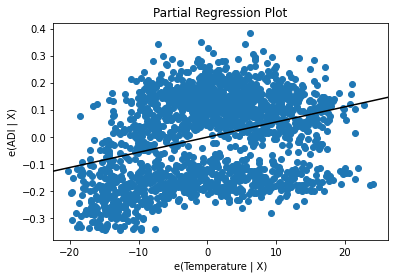

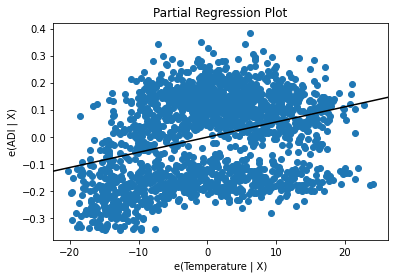

In [ ]:
sm.graphics.plot_partregress('ADI', 'Temperature', [], data=eco_df, obs_labels=False)

In [ ]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

# Create linear regression object
regr = linear_model.LinearRegression()

adi, temperature = eco_df['ADI'].to_numpy().reshape(-1,1), eco_df['Temperature'].to_numpy().reshape(-1,1)

# Train the model using the training sets
regr.fit(temperature, adi)

# Make predictions using the testing set
adi_y_pred = regr.predict(temperature)

# The coefficients
print('Coefficients: \n', regr.coef_)
# The mean squared error
print('Mean squared error: %.3f'
      % mean_squared_error(adi, adi_y_pred))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination (r2): %.3f'
      % r2_score(adi, adi_y_pred))

Coefficients: 
 [[0.00561131]]
Mean squared error: 0.023
Coefficient of determination (r2): 0.103


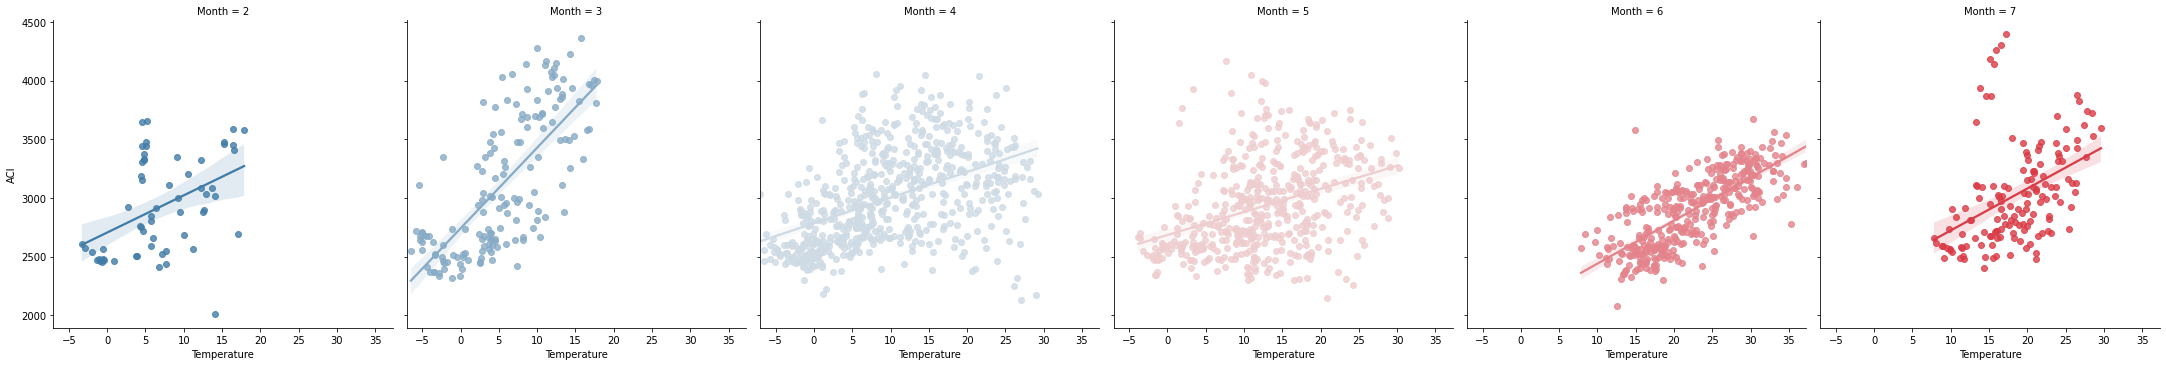

In [ ]:
sns.lmplot(data=eco_df, x='Temperature', y='ACI', col='Month', hue='Month', palette=sns.diverging_palette(240, 10, n=6, center='light'))

In [ ]:
eco_df

,Timestamp,ACI,ADI,Temperature,Humidity,Luminosity,Voltage,Week Number,Month
0,2019-05-11 15:00:00,3148.40665,0.5951,19.388740,39.736525,1194.102950,4.060485,18,5
1,2019-05-13 13:00:00,3424.68445,0.6312,10.626440,65.199975,174.656525,4.007870,19,5
2,2019-05-05 16:00:00,3459.26920,0.5760,12.212000,58.958290,393.096510,3.873020,18,5
3,2019-03-26 08:00:00,2962.10730,0.5836,7.322105,82.768820,359.876005,3.807890,12,3
5,2019-06-24 19:00:00,2641.96935,0.4665,18.470010,60.814765,58.026750,3.890070,25,6
...,...,...,...,...,...,...,...,...,...
3579,2019-03-11 15:00:00,3699.10365,0.5850,9.700465,42.631920,354.845675,3.991360,10,3
3581,2019-04-26 18:00:00,2781.67140,0.2706,17.765425,65.169220,99.834010,4.160185,16,4
3582,2019-05-29 21:00:00,2573.16015,0.4446,4.452015,90.804515,0.601545,3.920615,21,5
3583,2019-06-15 08:00:00,2801.27565,0.5159,25.105430,63.457610,334.049520,3.847780,23,6


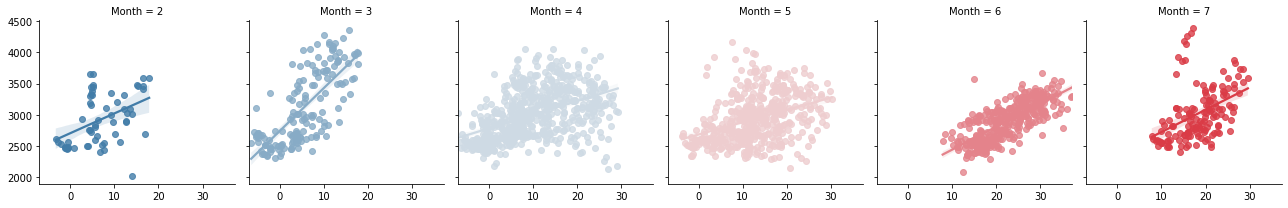

In [ ]:
g = sns.FacetGrid(data=eco_df, col='Month', hue='Month', palette=sns.diverging_palette(240, 10, n=6, center='light'))
g.map_dataframe(sns.regplot, x='Temperature', y='ACI')

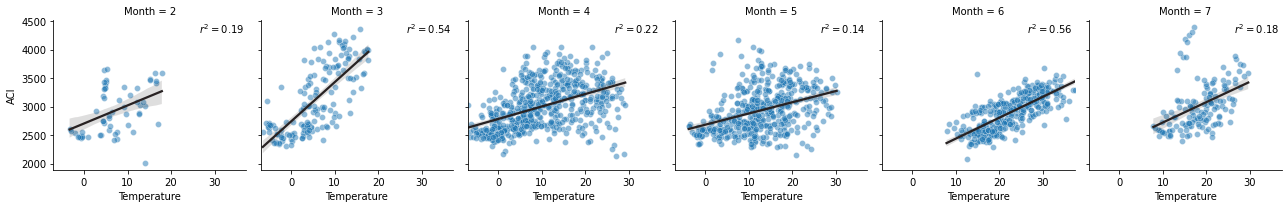

In [ ]:
def customreg2(x, y, hue=None, scatter_kws={}, reg_kws={}, **kwargs):
  sns.scatterplot(x, y, hue, palette=kwargs.get('palette'), **scatter_kws)
  sns.regplot(x, y, scatter=False, **reg_kws)

  # Calc R2
  x = sm.add_constant(x)

  model = sm.OLS(y, x)
  results = model.fit()

  plt.gca().annotate('$r^2=${:0.2f}'.format(results.rsquared), xy=(0.99,0.99), xycoords='axes fraction',
                     horizontalalignment='right', verticalalignment='top')


g = sns.FacetGrid(data=eco_df, col='Month', hue='Month', palette=sns.diverging_palette(240, 10, n=6, center='light'))
g.map(customreg, 'Temperature', 'ACI',
                scatter_kws={'alpha': 0.5}, reg_kws={'color':sns.diverging_palette(240, 10, n=3, center='dark')[1]})

# Ecological Data

In [ ]:
env_df = pd.read_csv('Environmental.csv', parse_dates=['Timestamp'])
env_df = env_df[env_df.loc[:,'Humidity'] <= 100.0]
env_df

,Timestamp,Humidity,Luminosity,Temperature,Voltage
0,2019-04-30 06:35:20,92.94825,149.80255,5.93515,3.93930
1,2019-05-12 11:40:37,42.36580,944.07615,19.77845,3.98720
3,2019-03-07 22:07:49,99.25740,0.00000,5.12170,3.77740
4,2019-05-05 02:37:45,98.34650,0.00000,-3.65790,3.84520
5,2019-05-15 16:48:12,31.40770,831.40000,19.60490,4.19780
...,...,...,...,...,...
38056,2019-06-25 08:10:49,83.49060,266.37880,23.03850,3.80560
38058,2019-05-25 06:10:53,97.12210,115.47540,10.92490,3.83980
38060,2019-06-21 08:34:19,94.67770,149.34050,17.89990,3.80315
38061,2019-03-03 20:17:49,93.62230,0.00000,5.12170,3.80320


# Combined Calculations

In [ ]:
# Create Weekly Env Calcs
env_weekly_g = env_df.groupby(env_df['Timestamp'].dt.weekofyear)
env_weekly = env_weekly_g.mean()
env_weekly['Environment'] = env_weekly_g.count()['Timestamp']
env_weekly = env_weekly.drop([8,29])

# Create Weekly Sonic Calcs
sonic_weekly_g = sonic_df.groupby(sonic_df['Timestamp'].dt.weekofyear)
sonic_weekly = sonic_weekly_g.mean()
sonic_weekly['Sonic'] = sonic_weekly_g.count()['Timestamp']
sonic_weekly = sonic_weekly.drop([8,29])

# Join
weekly = env_weekly.join(sonic_weekly)
weekly.index.rename('Week', inplace=True)
weekly

,Humidity,Luminosity,Temperature,Voltage,Environment,ACI,ADI,Sonic
Week,,,,,,,,
9,79.851032,241.301929,6.295062,3.835781,1103,2795.577608,0.216851,136
10,86.772985,155.320681,4.932761,3.816730,617,3384.926460,0.301367,15
11,84.996656,241.434536,4.944351,3.832730,652,3274.453798,0.252228,53
12,81.483035,274.774141,6.560224,3.847555,914,2934.679701,0.241975,83
13,74.900589,406.410596,8.911875,3.901355,1079,3070.777081,0.244220,196
14,64.151398,359.307412,9.269286,4.046221,1678,3061.080732,0.273643,273
15,67.247200,334.240102,4.462586,3.942762,1693,3032.094702,0.239331,257
16,57.213540,536.010726,9.894179,4.065167,1659,2959.279524,0.232108,272
17,66.662138,494.796088,14.704925,4.052771,1262,2995.078898,0.272290,263


In [ ]:
# Create Weekly Env Calcs
env_hourly_g = env_df.groupby(env_df['Timestamp'].dt.hour)
env_hourly = env_hourly_g.mean()
env_hourly['Environment'] = env_hourly_g.count()['Timestamp']

# Create Weekly Sonic Calcs
sonic_hourly_g = sonic_df.groupby(sonic_df['Timestamp'].dt.hour)
sonic_hourly = sonic_hourly_g.mean()
sonic_hourly['Sonic'] = sonic_hourly_g.count()['Timestamp']

# Join
hourly = env_hourly.join(sonic_hourly)
hourly.index.rename('Hour', inplace=True)
hourly

,Humidity,Luminosity,Temperature,Voltage,Environment,ACI,ADI,Sonic
Hour,,,,,,,,
0,89.728631,0.000000,4.447324,3.924467,742,2774.791702,0.180628,169
1,90.368060,0.000000,4.126629,3.922833,679,2763.432391,0.172617,164
2,91.264134,0.091471,3.712692,3.919596,605,2707.423850,0.179743,159
3,91.952849,1.755293,3.291028,3.916799,578,2645.037414,0.189376,173
4,91.852357,13.118280,3.386060,3.906288,525,2707.355090,0.209230,166
5,91.705968,56.529819,4.904488,3.891727,592,2772.675669,0.240905,144
6,88.349894,145.769242,9.121003,3.872945,813,2826.691354,0.258471,156
7,80.842069,232.972337,12.756040,3.864513,970,2928.090460,0.267883,154
8,73.554040,334.389605,14.600297,3.856890,1139,3044.917793,0.273552,151


## Reading Numbers

### Weekly

In [ ]:
weekly_melted = weekly.reset_index().melt(id_vars=['Week'], var_name='Metric', value_vars=['Sonic','Environment','Luminosity','Voltage'], value_name='Value')
weekly_melted

,Week,Metric,Value
0,9,Sonic,136.000000
1,10,Sonic,15.000000
2,11,Sonic,53.000000
3,12,Sonic,83.000000
4,13,Sonic,196.000000
...,...,...,...
75,24,Voltage,3.862526
76,25,Voltage,3.849009
77,26,Voltage,3.847712
78,27,Voltage,3.837102


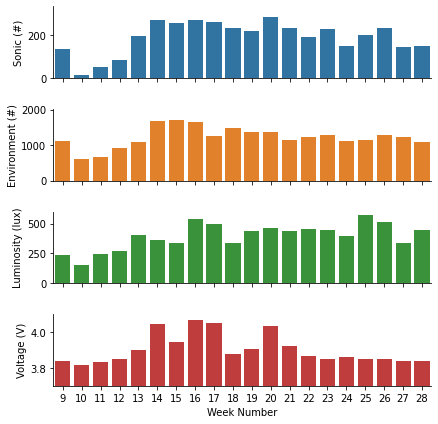

In [ ]:
labels = {
    'Sonic': 'Sonic (#)',
    'Environment': 'Environment (#)',
    'Luminosity': 'Luminosity (lux)',
    'Voltage': 'Voltage (V)',
}

counts_height = 1.5

g = sns.FacetGrid(weekly_melted, row="Metric", hue='Metric', sharey=False, aspect=4, height=counts_height)
g.map_dataframe(sns.barplot, x='Week', y='Value')

g.axes.flat[0].set(ylim=(0, 48*7))
g.axes.flat[1].set(ylim=(0, 288*7))
g.axes.flat[3].set(ylim=(3.7, 4.1))

for ax, label in zip(g.axes.flat, labels.values()):
  ax.set_ylabel(label)

g.set_titles(col_template="", row_template="")
g.set_xlabels('Week Number')

g.savefig('weekly_counts.pdf')

### Hourly

In [ ]:
hourly_melted = hourly.reset_index().melt(id_vars=['Hour'], var_name='Metric', value_vars=['Sonic','Environment','Luminosity','Voltage'], value_name='Value')
hourly_melted

,Hour,Metric,Value
0,0,Sonic,169.000000
1,1,Sonic,164.000000
2,2,Sonic,159.000000
3,3,Sonic,173.000000
4,4,Sonic,166.000000
...,...,...,...
91,19,Voltage,3.943597
92,20,Voltage,3.936765
93,21,Voltage,3.931662
94,22,Voltage,3.932944


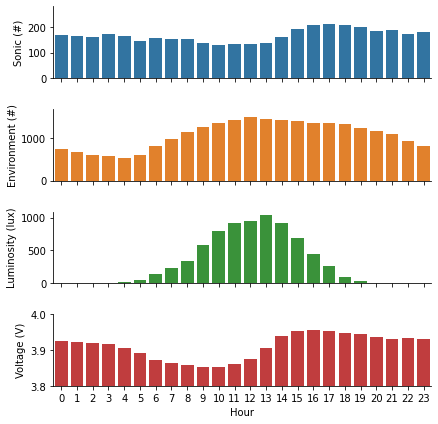

In [ ]:
labels = {
    'Sonic': 'Sonic (#)',
    'Environment': 'Environment (#)',
    'Luminosity': 'Luminosity (lux)',
    'Voltage': 'Voltage (V)',
}

counts_height = 1.5

g = sns.FacetGrid(hourly_melted, row="Metric", hue='Metric', sharey=False, aspect=4, height=counts_height)
g.map_dataframe(sns.barplot, x='Hour', y='Value')

g.axes.flat[0].set(ylim=(0, 2*7*20))
g.axes.flat[1].set(ylim=(0, 12*7*20))
g.axes.flat[3].set(ylim=(3.8, 4.0))

for ax, label in zip(g.axes.flat, labels.values()):
  ax.set_ylabel(label)

g.set_titles(col_template="", row_template="")
g.set_xlabels('Hour')

g.savefig('hourly_counts.pdf')

# Power Data

In [ ]:
power_df = pd.read_csv('Power.csv', parse_dates=['Timestamp'])
power_df

,Action,Voltage,Timestamp,Table Names
0,NaN,4.1815,2019-01-15 12:15:05,BATT.CSV
1,NaN,4.1754,2019-01-15 12:20:05,BATT.CSV
2,NaN,4.1720,2019-01-15 12:25:05,BATT.CSV
3,NaN,4.1828,2019-01-15 13:39:00,BATT.CSV
4,NaN,4.1793,2019-01-15 13:44:00,BATT.CSV
...,...,...,...,...
64054,wake,3.8600,2019-07-17 12:51:59,SLEEP.CSV
64055,sleep,3.8645,2019-07-17 13:06:59,SLEEP.CSV
64056,wake,3.8600,2019-07-17 13:22:00,SLEEP.CSV
64057,sleep,3.8903,2019-07-17 13:37:00,SLEEP.CSV


In [ ]:
from datetime import datetime, timedelta

start = datetime(2019,2,18,18,1,10)
duration = timedelta(minutes=750)

full_power = power_df
full_power = full_power[full_power['Timestamp'] >= start][full_power['Timestamp'] < start + duration]
full_power['Minutes'] = (full_power['Timestamp'] - start).dt.total_seconds()/60
full_power

,Action,Voltage,Timestamp,Table Names,Minutes
9839,NaN,4.0968,2019-02-18 18:01:10,BATT.CSV,0.000000
9840,NaN,4.1045,2019-02-18 18:06:11,BATT.CSV,5.016667
9841,NaN,4.0981,2019-02-18 18:11:11,BATT.CSV,10.016667
9842,NaN,4.0957,2019-02-18 18:21:11,BATT.CSV,20.016667
9843,NaN,4.1032,2019-02-18 18:21:11,BATT.CSV,20.016667
...,...,...,...,...,...
54093,sleep,3.9097,2019-02-19 05:16:33,SLEEP.CSV,675.383333
54094,wake,3.9100,2019-02-19 05:31:34,SLEEP.CSV,690.400000
54095,sleep,3.9742,2019-02-19 05:46:34,SLEEP.CSV,705.400000
54096,wake,3.9700,2019-02-19 06:01:35,SLEEP.CSV,720.416667


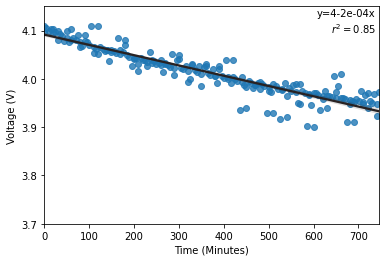

In [ ]:
sns.regplot(data=full_power, x='Minutes',y='Voltage', line_kws={'color':sns.diverging_palette(240, 10, n=3, center='dark')[1]})
# Calc R2

x = full_power['Minutes']
y = full_power['Voltage']
x = sm.add_constant(x)

model = sm.OLS(y, x)
results = model.fit()

results.summary()

plt.gca().set_ylim(3.7,4.15)

plt.gca().annotate('y={:1.0f}{:1.0e}x\n$r^2=${:0.2}'.format(results.params['const'], results.params['Minutes'], results.rsquared), xy=(0.99,0.99), xycoords='axes fraction',
                    horizontalalignment='right', verticalalignment='top')
plt.gca().set_ylabel('Voltage (V)')
plt.gca().set_xlabel('Time (Minutes)')

plt.savefig('full_power.pdf')

In [ ]:
start = datetime(2019,2,20,18,2,55)
duration = timedelta(minutes=750)

low_power = power_df
low_power = low_power[low_power['Timestamp'] >= start][low_power['Timestamp'] < start + duration]
low_power['Minutes'] = (low_power['Timestamp'] - start).dt.total_seconds()/60
low_power

,Action,Voltage,Timestamp,Table Names,Minutes
10415,NaN,3.8161,2019-02-20 18:02:55,BATT.CSV,0.0
10416,NaN,3.7785,2019-02-20 18:07:55,BATT.CSV,5.0
10417,NaN,3.7968,2019-02-20 18:12:55,BATT.CSV,10.0
10418,NaN,3.7957,2019-02-20 18:17:55,BATT.CSV,15.0
10419,NaN,3.8000,2019-02-20 18:22:55,BATT.CSV,20.0
...,...,...,...,...,...
10560,NaN,3.8022,2019-02-21 06:07:55,BATT.CSV,725.0
10561,NaN,3.7742,2019-02-21 06:12:55,BATT.CSV,730.0
10562,NaN,3.7935,2019-02-21 06:17:55,BATT.CSV,735.0
10563,NaN,3.7710,2019-02-21 06:22:55,BATT.CSV,740.0


In [ ]:
'{:1.1} > {:1.0e}'.format(0.00152, 0.00152)

'0.002 > 2e-03'

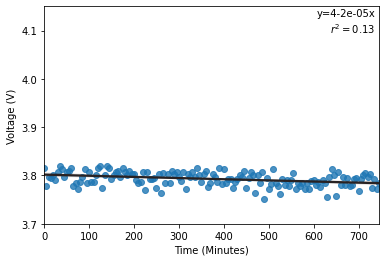

In [ ]:
sns.regplot(data=low_power, x='Minutes',y='Voltage', line_kws={'color':sns.diverging_palette(240, 10, n=3, center='dark')[1]})
# Calc R2

x = low_power['Minutes']
y = low_power['Voltage']
x = sm.add_constant(x)

model = sm.OLS(y, x)
results = model.fit()

results.summary()

plt.gca().set_ylim(3.7,4.15)

plt.gca().annotate('y={:1.0f}{:1.0e}x\n$r^2=${:0.2}'.format(results.params['const'], results.params['Minutes'], results.rsquared), xy=(0.99,0.99), xycoords='axes fraction',
                    horizontalalignment='right', verticalalignment='top')
plt.gca().set_ylabel('Voltage (V)')
plt.gca().set_xlabel('Time (Minutes)')

plt.savefig('low_power.pdf')

# Download Plots

In [ ]:
!tar -cJvf plot.tar.xz *.pdf

from google.colab import files
files.download('plot.tar.xz')

full_power.pdf
hourly_counts.pdf
hourly_indices.pdf
low_power.pdf
monthly_indices.pdf
pairplot_month.pdf
pairplot_week.pdf
weekly_counts.pdf
weekly_indices.pdf


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>